[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lorenzo-arcioni/BLAST-OUT-postprocessing/blob/main/BLAST%20post-processing%20tsv%20parser.ipynb)

# Post-processing tool for tabular BLAST output

These Jupyter Notebooks support the analysis of homology-based annotation results generated by BLAST or Diamond annotation software. The tools allow users to generate informative graphs and reports to aid in the interpretation of tabular annotation files obtained during the annotation process. The required dependencies for the notebook to run include the pandas, matplotlib, numpy, ipywidgets and math libraries.

By following the instructions provided, users will be guided through the process of setting the parameters for their analysis. Once these parameters have been set, users can execute the notebook's cells one by one. It is strongly recommended that users follow the instructions step-by-step to ensure proper use of the tool.

Through interactive code snippets and visualizations, users will learn how to manipulate and plot data generated from homology-based annotation pipelines, including gene expression profiles, and sequence alignments metadata. With this Jupyter Notebook, users can quickly and easily explore their annotation data and gain deeper insights into the underlying biological processes at play.

Whether you're an experienced bioinformatician or new to the field, these notebooks are an essential tool for anyone looking to conduct homology-based annotation analysis and generate informative plots and reports for their research.

In [1]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from math import log10, floor
from IPython.display import Markdown

import matplotlib.cm as cm
import ipywidgets as widgets

%matplotlib inline

#Useful function for displaying more data
def display_all(df):
    with pd.option_context("display.max_columns", 1000):
        display(df)

#Find the exponent of a float number in scientific notation
def find_exp(number) -> int:
    if abs(number) == 0:
        return 0
    base10 = log10(abs(number))
    return abs(floor(base10))

plt.rcParams['figure.dpi'] = 110

## Preliminary phase

### Parameter configuration section

This section is responsible for loading the dataframe and allows the user to set the following parameters for their analysis:
- Input file name
- BLAST output format (each subsequent section will require specific information)
- Title for their graphs (we recommend a title that reflects the annotation information, such as the database name or BLAST type, or the scientific name of the organism being analyzed)
- Path for saving the image or graph

In [84]:
#Insert the name (or path) of the tsv file
filename = "./salamandra/fast-slow.cds_nr.tsv"

#Insert the outformat
outformat = "qseqid qlen sseqid sallseqid slen qstart qend sstart send qseq full_qseq sseq full_sseq evalue bitscore score length pident nident mismatch positive gapopen gaps ppos qframe btop cigar staxids sscinames sskingdoms skingdoms sphylums stitle salltitles qcovhsp scovhsp qtitle qqual full_qqual qstrand"

#Import the dataset
df = pd.read_csv(filename, sep="\t", names=outformat.split())

#Insert the title of graph
title = "Salamandra salamandra Blastx NR"

#Filename for output
path = "./salamandra/fast_slow_graphs/" + title;

### Deleting less significant hits

This cell allows the user to obtain only the most significant hit for each sequence by eliminating all other hits from the dataframe. It is recommended to execute this cell only if the user wants to remove all non-significant hits and keep only the most significant hit for each sequence.


In [85]:
df = df.groupby('qseqid').first().reset_index()

## Section for analyzing the hit rate of protein functions

The hitrate graph is important in homology annotation because it provides a measure of the quality of the annotation. The hitrate represents the percentage of sequences that have a significant hit in the database for a particular organism. If the hitrate is low, it may indicate that the database is incomplete or that the annotation algorithm is not performing well for that particular organism. Conversely, a high hitrate suggests a good coverage of the organism's proteome in the database and a reliable annotation. Therefore, the hitrate graph can help researchers assess the quality of the annotation and identify areas where improvements are needed.

In this section, it is possible to obtain bar charts highlighting the most common protein functions that were found across all input sequences. Two charts will be generated: one showing the protein ID bar chart and one showing the protein function name count bar chart.

Please note that to run these cells, it is necessary to have "sseqid" and "stitle" as part of the output format information.


#### Accession Graph

A graph of accessions is a graphical representation that shows the number of hits associated with each protein accession in a BLAST or Diamond search result. It can be used to quickly identify the most frequently matched proteins in the search and to gain insights into the functional annotation of the input sequences. The Y-axis of the graph represents the protein accession numbers, while the X-axis represents the number of hits associated with each accession.

In [86]:
# Series with accession id and count
hits = df['sseqid'].value_counts()

# Insert the number of results (default 15)
results_number = 15

# Drop the last len(h) - results_number lines, only if  len(h) > results_number
if len(hits) > results_number:
    hits.drop(hits.tail(len(hits) - results_number).index, inplace=True)

# Set appropriate figsize
plt.rcParams["figure.figsize"] = (8, min(results_number//2 - results_number//4 + 1, len(hits)//2 - len(hits)//4 + 2))

# Sortting and adjusting data
hits.sort_values(inplace=True)
hits.reset_index(drop=True);

Run this cell to plot the results!

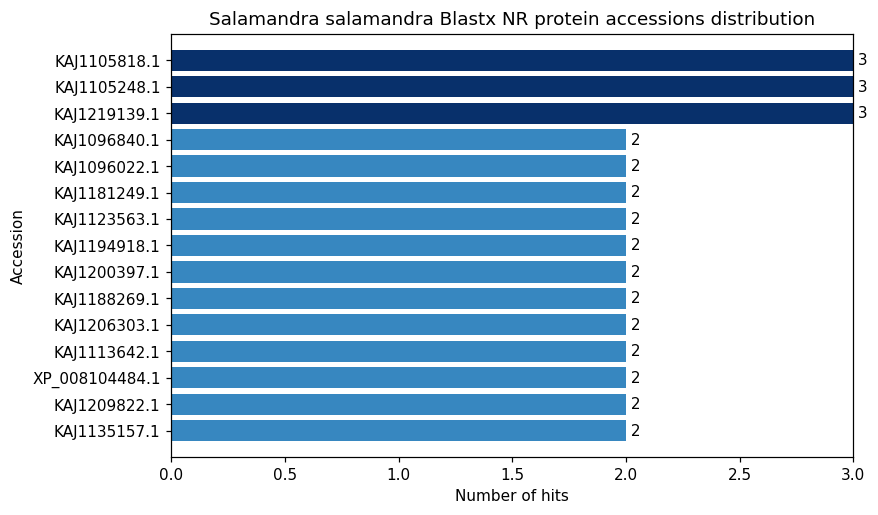

In [87]:
# Creating the graph with color
colors = cm.Blues(hits.values / float(max(hits.values)))
plt.barh(hits.index, hits.values, color=colors)
plt.ylim([-1,len(hits.index)])
plt.xlim([0, hits[-1] + hits.values[0]//5])

# Insert labels
for index, value in enumerate(hits.values):
    plt.text(value, index, " " + str(value), va='center')

# Set title and axis labels
plt.xlabel('Number of hits')
plt.ylabel('Accession')
plt.title(title + ' protein accessions distribution')

# Save and plot!
plt.savefig(path + '_protein_accessions.png', bbox_inches = 'tight', dpi=300)
plt.show()

#### Section for selecting annotation database

In this section, you can select the database on which the annotation operations have been performed. This is because the result storage system varies from database to database.

In [2]:
# Widget radio button
database =widgets.Select(
    options=['NR', 'TrEMBL', 'Swiss-Prot'],
    value='NR',
    description='Select the database:',
    disabled=False,
    style={'description_width': 'initial'}
)
display(database)

Select(description='Select the database:', options=('NR', 'TrEMBL', 'Swiss-Prot'), style=DescriptionStyle(desc…

Now execute this cell to make effective the changes

In [88]:
if database.value == 'NR':    
    def get_sciname(x):
        
        os_index = - x[::-1].index('[')

        return x[os_index:-1]

    # Useful functions
    def get_protein_function(x):

        x_l = x.split(" ")

        return ' '.join(x_l[1:x_l.index(next(x for x in x_l if x.startswith('[')))])
else:
    def get_sciname(x):

        os_index = x.index('OS=')
        ox_index = x.index('OX=')

        return x[os_index+3:ox_index-1]

    # Useful functions
    def get_protein_function(x):

        x_l = x.split(" ")

        return ' '.join(x_l[1:x_l.index(next(x for x in x_l if x.startswith('OS=')))])

### Protein functions graph

In this section, a bar chart can be generated showing the count of protein function names associated with the annotation.
You can change the default values of the results number.

In [89]:
# Create a new column in the dataframe
df['protein_function'] = df['stitle'].apply(lambda x: get_protein_function(x))

# Series with accession id and count
proteins  = df['protein_function'].value_counts()

# Insert all index to remove from the plot
try:
    proteins = proteins[~proteins.index.str.contains('ncharacterized', regex=True, na=False)]
    proteins = proteins[~proteins.index.str.contains('ypothetical', regex=True, na=False)]
    proteins = proteins[~proteins.index.str.contains('nnamed', regex=True, na=False)]
except:
    pass

# Insert the number of results
results_number = 15

# Drop the last len(h) - results_number lines, only if  len(h) > results_number
if len(proteins) > results_number:
    proteins.drop(proteins.tail(len(proteins) - results_number).index, inplace=True)

# Sorting and adjusting data
proteins.sort_values(inplace=True)
proteins.reset_index(drop=True)
proteins.sort_values(ascending=True, inplace=True)

Now execute cell below to plot the bar chart!

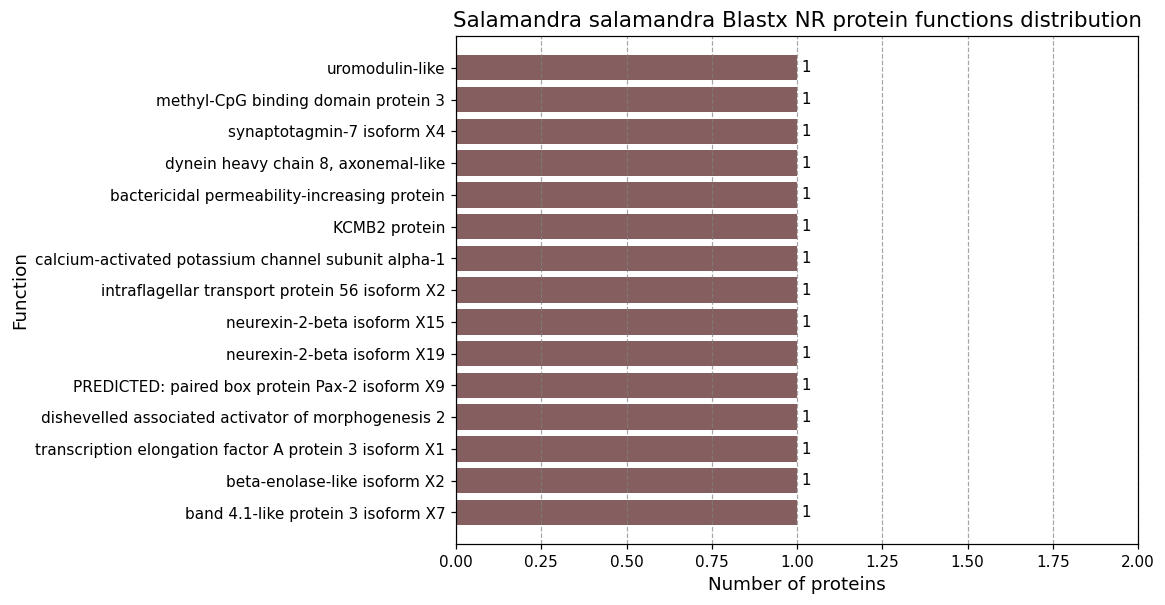

In [90]:
# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(proteins.index, proteins.values, color='#855F5F')

#Set appropriate figsize
plt.rcParams["figure.figsize"] = (8, min(results_number//2 - results_number//4 + 1, len(proteins)//2 - len(proteins)//4 + 2))

# Set the x-axis and y-axis limits
ax.set_xlim([0, proteins[-1] + proteins.values[0]])
ax.set_ylim([-1, len(proteins.index)])

# Insert labels with values inside each bar
for index, value in enumerate(proteins.values):
    ax.text(value, index, " " + str(value), ha='left', va='center')

# Set axis labels and title
ax.set_xlabel('Number of proteins', fontsize=12)
ax.set_ylabel('Function', fontsize=12)
ax.set_title(title + ' protein functions distribution', fontsize=14)

# Add grid lines
ax.xaxis.grid(color='gray', linestyle='--', alpha=0.7)

# Save and display the chart
plt.savefig(path + '_protein_functions.png', bbox_inches = 'tight', dpi=300)
plt.show()

## Section for analyzing the hit rate of organisms

Similarly to the protein function chart, we can obtain a bar chart that allows us to understand whether the organism under examination is evolutionarily close to another organism present in the database.

In this section, it is possible to obtain bar charts highlighting the most common organisms that were found across all input sequences.
Please note that to run these cells, it is necessary to have "sseqid" and "stitle" as part of the output format information.

#### Scientific names graph

You can change the default values of the results number.

In [92]:
# Create a new column in the dataframe
df['scientific_name']  = df['stitle'].apply(lambda x: get_sciname(x))

# Series with scientific names
sci_names = df['scientific_name'].value_counts()

# Insert the number of results (default 15)
results_number = 15

if len(sci_names) > results_number:
    sci_names.drop(sci_names.tail(len(sci_names) - results_number).index, inplace=True)

# Sorting and adjusting data
sci_names.sort_values(inplace=True)
sci_names.reset_index(drop=True);

Now execute the cell below to plot!

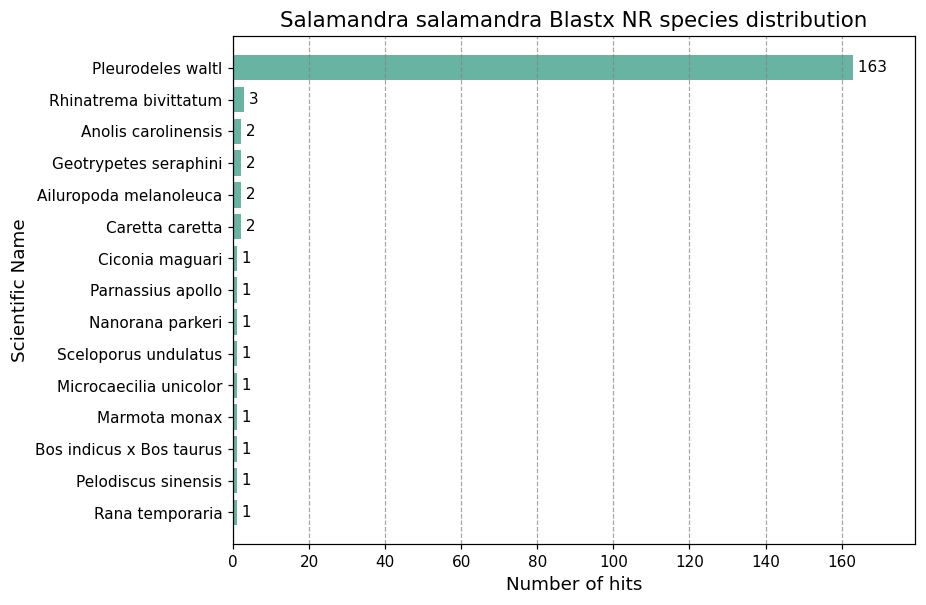

In [93]:
# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(sci_names.index, sci_names.values, color='#69b3a2')

#Set appropriate figsize
plt.rcParams["figure.figsize"] = (8, min(results_number//2 - results_number//4 + 1, len(sci_names)//2 - len(sci_names)//4 + 2))

# Set the x-axis and y-axis limits
ax.set_xlim([0, sci_names.max() + sci_names.max()*0.1])
ax.set_ylim([-1, len(sci_names.index)])

# Insert labels with values inside each bar
for index, value in enumerate(sci_names.values):
    ax.text(value, index, " " + str(value), ha='left', va='center')

# Set axis labels and title
ax.set_xlabel('Number of hits', fontsize=12)
ax.set_ylabel('Scientific Name', fontsize=12)
ax.set_title(title + ' species distribution', fontsize=14)

# Add grid lines
ax.xaxis.grid(color='gray', linestyle='--', alpha=0.7)

# Save and display the chart
plt.savefig(path + '_species.png', bbox_inches = 'tight', dpi=300)
plt.show()

## Hit count bar chart

In this section, it is possible to generate a bar chart of hits for each match in the annotation results (if the limit has been set, it will be a bar chart with all values at 1). 

Here it is also possible to modify the default value of the number of results.

In [94]:
# Series with names and count
hits = df['qseqid'].value_counts()

# Insert the number of results (default 30)
results_number = 30

# Drop the last len(h) - results_number lines, only if  len(h) > results_number
if len(hits) > results_number:
    hits.drop(hits.tail(len(hits) - results_number).index, inplace=True)

# Set appropriate figsize
plt.rcParams["figure.figsize"] = (8, min(results_number//2 - results_number//4 + 1, len(hits)//2 - len(hits)//4 + 2))

And now plot!

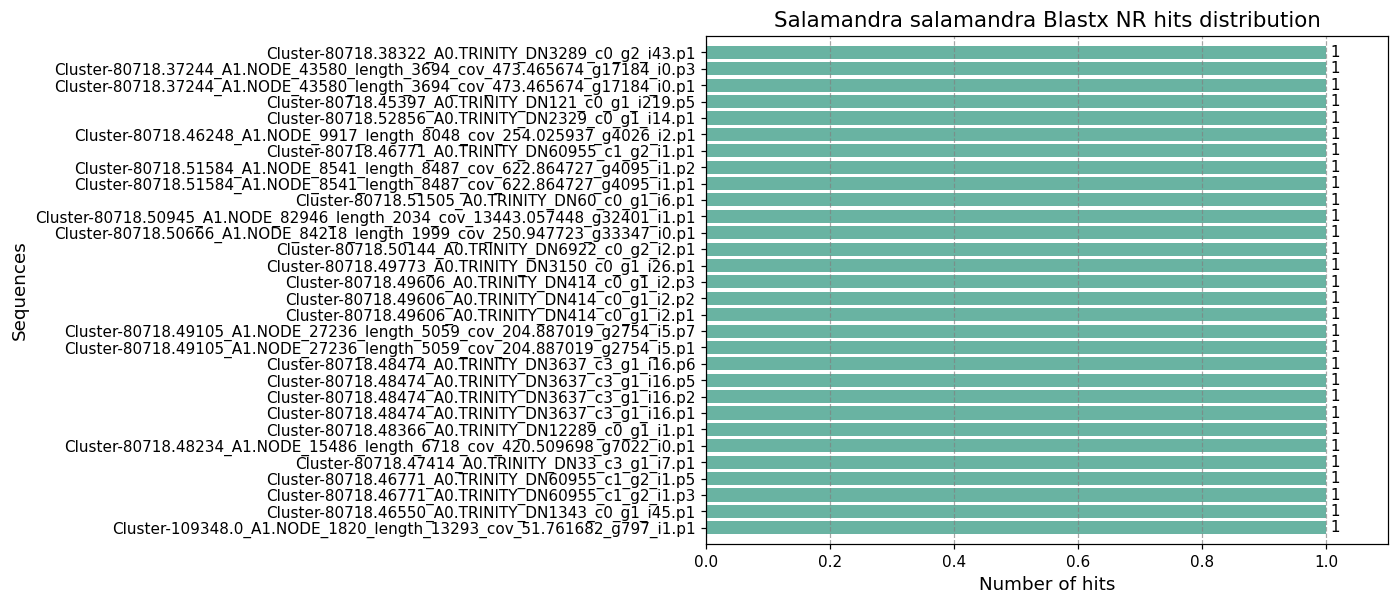

In [95]:
# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(hits.index, hits.values, color='#69b3a2')

# Set the x-axis and y-axis limits
ax.set_xlim([0, hits.max() + hits.max()*0.1])
ax.set_ylim([-1, len(hits.index)])

# Insert labels with values inside each bar
for index, value in enumerate(hits.values):
    ax.text(value, index, " " + str(value), ha='left', va='center')

# Set axis labels and title
ax.set_xlabel('Number of hits', fontsize=12)
ax.set_ylabel('Sequences', fontsize=12)
ax.set_title(title + ' hits distribution', fontsize=14)

# Add grid lines
ax.xaxis.grid(color='gray', linestyle='--', alpha=0.7)

# Save and display the chart
plt.savefig(path + '_hits.png', bbox_inches = 'tight', dpi=300)
plt.show()

## Distribution of e-value from annotation results file

The e-value is a statistical measure used in bioinformatics to assess the significance of sequence similarity search results. It represents the expected number of hits with a similar score that would be obtained by chance alone when searching a database of a certain size. A lower e-value indicates a more significant match between the query sequence and the database sequence.

In this section, you can extract the e-value from the annotation results file and plot a histogram representing the distribution of the e-value for all the hits. To perform this analysis, it is necessary to have the 'evalue' parameter in the tabular output format.

In [96]:
#Series with e-value of subject sequenceid
evalues_series = df["evalue"].copy()

#Setting the figsize
plt.rcParams["figure.figsize"] = (5, 5)

Now you can plot!

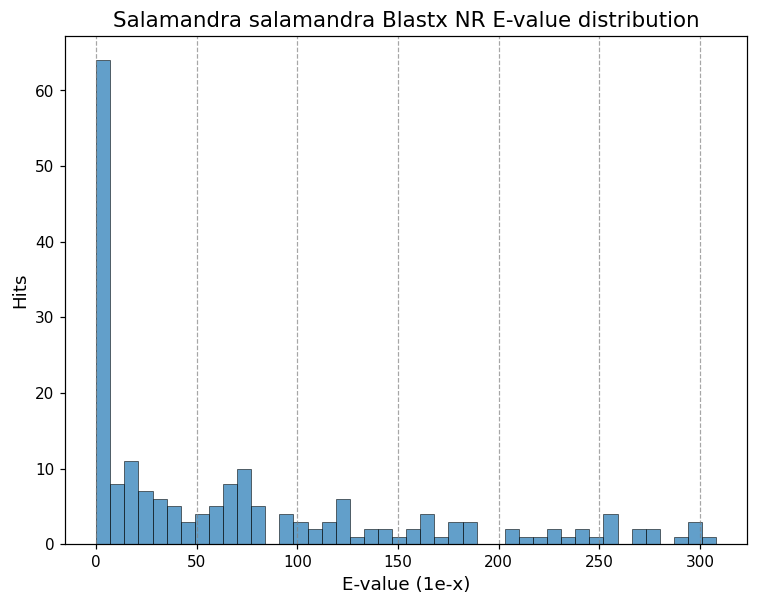

In [97]:
# Sort the DataFrame by e-value
evalues_series.sort_values(inplace=True, ascending=True)

# Create a list of exponents of all e-value of dataframe
evalues = list(evalues_series.values)
evalues = [np.format_float_scientific(x, precision=4, exp_digits=3) for x in evalues]
evalues_exp = [find_exp(float(x)) for x in evalues]

# Create the histogram with a color palette
fig, ax = plt.subplots(figsize=(8, 6))
n, bins, patches = ax.hist(evalues_exp, bins=[x for x in range(0, max(evalues_exp), max(evalues_exp)//40)], 
                           edgecolor='black', linewidth=0.5, alpha=0.7)

# Set the x-axis and y-axis limits
#ax.set_xlim([-40, 1])
#ax.set_ylim([0, max(ax.get_yticks())])

# Set axis labels and title
ax.set_xlabel('E-value (1e-x)', fontsize=12)
ax.set_ylabel('Hits', fontsize=12)
ax.set_title(title + ' E-value distribution', fontsize=14)

# Add grid lines
ax.xaxis.grid(color='gray', linestyle='--', alpha=0.7)

# Save and display the chart
plt.savefig(path + '_evalue.png', bbox_inches = 'tight', dpi=300)
plt.show()

## Bit-score distribution analysis

The bitscore is a statistical measure that represents the relative quality of the alignment between a query sequence and a subject sequence in a sequence database. It is calculated from the raw score, which is the sum of the match, mismatch, and gap scores between the query and subject sequences, and takes into account the size of the database being searched. A higher bitscore indicates a better alignment and a higher degree of similarity between the query and subject sequences. The bitscore is commonly used as a criterion for evaluating the significance of sequence alignments and identifying potential homologous sequences.

In this section, similarly to the previous one, it is possible to generate a histogram graph that shows the distribution of the bitscore value for each match.

To perform this analysis, it is necessary to have the 'bitscore' parameter in the tabular output format.

In [98]:
#Series with bit-score of subject sequenceid
bitscores = df["bitscore"].copy()

#Setting the figsize
plt.rcParams["figure.figsize"] = (5, 5)

And now plot!

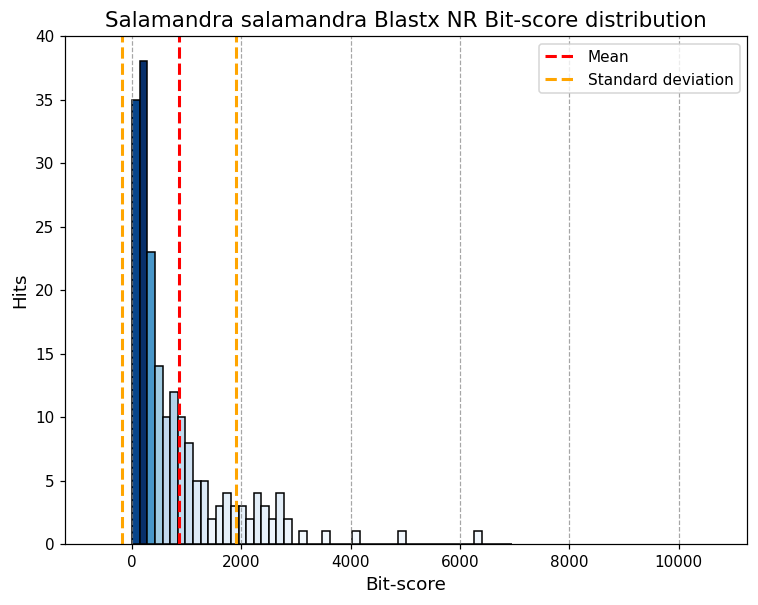

In [99]:
# Sorting by bit-score
bitscores.sort_values(inplace=True, ascending=True)

# Adjusting the indexes
bitscores.reset_index(drop=True, inplace=True)

# Create the histogram
fig, ax = plt.subplots(figsize=(8, 6))
n, bins, patches = ax.hist(bitscores.values, bins=[x for x in range(0, int(max(bitscores.values)), int(max(bitscores.values))//50)], color='steelblue', edgecolor='black')

# Set the x-axis and y-axis limits
ax.set_xlim([0, max(bitscores.values)])
ax.set_ylim([0, max(ax.get_yticks())])

# Set axis labels and title
ax.set_xlabel('Bit-score', fontsize=12)
ax.set_ylabel('Hits', fontsize=12)
ax.set_title(title + ' Bit-score distribution', fontsize=14)

# Add grid lines
ax.xaxis.grid(color='gray', linestyle='--', alpha=0.7)

# Calculate mean and standard deviation
mean = bitscores.values.mean()
std = bitscores.values.std()

# Add mean and standard deviation lines
ax.axvline(mean, color='red', linestyle='--', linewidth=2)
ax.axvline(mean - std, color='orange', linestyle='--', linewidth=2)
ax.axvline(mean + std, color='orange', linestyle='--', linewidth=2)

# Adding the legend
plt.legend(['Mean', 'Standard deviation'])

# Set the color of each patch based on its height
bin_centers = 0.5 * (bins[:-1] + bins[1:])
colormap = plt.cm.ScalarMappable(cmap='Blues')
colormap.set_clim(0, max(n))
for c, p in zip(colormap.to_rgba(n), patches):
    plt.setp(p, 'facecolor', c)

# Zoom in around the mean
ax.set_xlim([mean - 2*std, mean + 10*std])

# Save and display the chart
plt.savefig(path +'_bitscore.png', bbox_inches='tight', dpi=300)
plt.show()

## Length and Similarity distribution

In a homology annotation process, the similarity score and length score are important measures to assess the degree of similarity between a query sequence and a sequence in a reference database.

The similarity score is typically calculated as the percentage of identical amino acids or nucleotides between the two sequences, and it provides a measure of how closely related the two sequences are. A high similarity score suggests that the two sequences share a common evolutionary origin and may have similar biological functions.

The length score, on the other hand, measures the length of the matching region between the two sequences. It is important because it provides additional information about the degree of similarity between the two sequences. A longer matching region indicates a stronger similarity between the two sequences, while a shorter region may suggest that the two sequences are only partially homologous.

Overall, the similarity and length scores are important measures to consider when assessing the significance of a homology match between a query sequence and a sequence in a reference database.

To obtain the results in this section, it is essential to have length ('length') and percent identity ('pident') information in the output file.

### Length distribution

This chart displays the distribution of all calculated sequence lengths, shows the overall performance of the alignments and helps to adjust the annotation score in the annotation step.

In [100]:
#Series with length of subject sequenceid
length = df["length"].copy()

#Setting the figsize
plt.rcParams["figure.figsize"] = (5, 5)

And now plot!

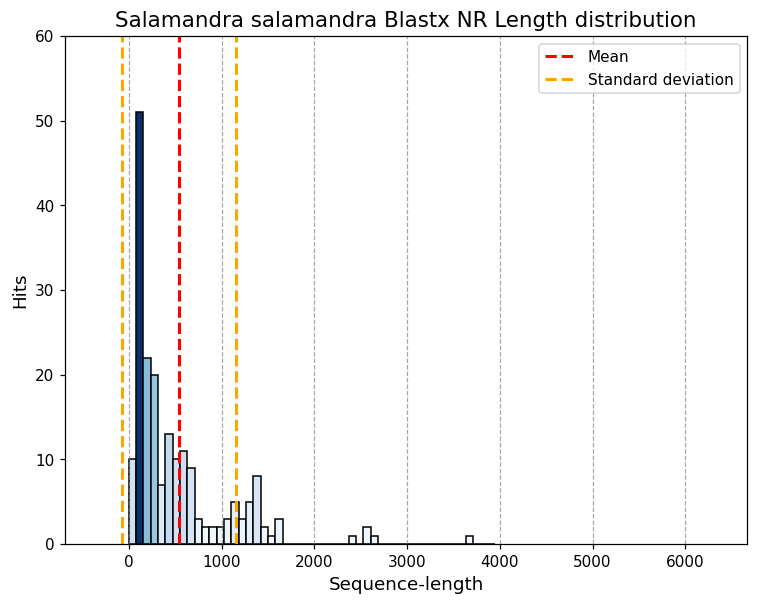

In [101]:
# Sorting by bit-score
length.sort_values(inplace=True, ascending=True)

# Adjusting the indexes
length.reset_index(drop=True, inplace=True)

# Create the histogram
fig, ax = plt.subplots(figsize=(8, 6))
n, bins, patches = ax.hist(length.values, bins=[x for x in range(0, int(max(length.values)), int(max(length.values))//50)], color='steelblue', edgecolor='black')

# Set the x-axis and y-axis limits
ax.set_xlim([0, max(length.values)])
ax.set_ylim([0, max(ax.get_yticks())])

# Set axis labels and title
ax.set_xlabel('Sequence-length', fontsize=12)
ax.set_ylabel('Hits', fontsize=12)
ax.set_title(title + ' Length distribution', fontsize=14)

# Add grid lines
ax.xaxis.grid(color='gray', linestyle='--', alpha=0.7)

# Calculate mean and standard deviation
mean = length.values.mean()
std  = length.values.std()

# Add mean and standard deviation lines
ax.axvline(mean, color='red', linestyle='--', linewidth=2)
ax.axvline(mean - std, color='orange', linestyle='--', linewidth=2)
ax.axvline(mean + std, color='orange', linestyle='--', linewidth=2)

# Adding the legend
plt.legend(['Mean', 'Standard deviation'])

# Set the color of each patch based on its height
bin_centers = 0.5 * (bins[:-1] + bins[1:])
colormap = plt.cm.ScalarMappable(cmap='Blues')
colormap.set_clim(0, max(n))
for c, p in zip(colormap.to_rgba(n), patches):
    plt.setp(p, 'facecolor', c)

# Zoom in around the mean
ax.set_xlim([mean - 2*std, mean + 10*std])

# Save and display the chart
plt.savefig(path +'_lendistribution.png', bbox_inches='tight', dpi=300)
plt.show()

### Similarity distribution

This chart displays the distribution of all calculated sequence similarities (percentages), shows the overall performance of the alignments and helps to adjust the annotation score in the annotation step.

In [102]:
# Get the identity percentage
pidents = df["pident"].copy()

#Setting the figsize
plt.rcParams["figure.figsize"] = (5, 5)

And now plot the results!

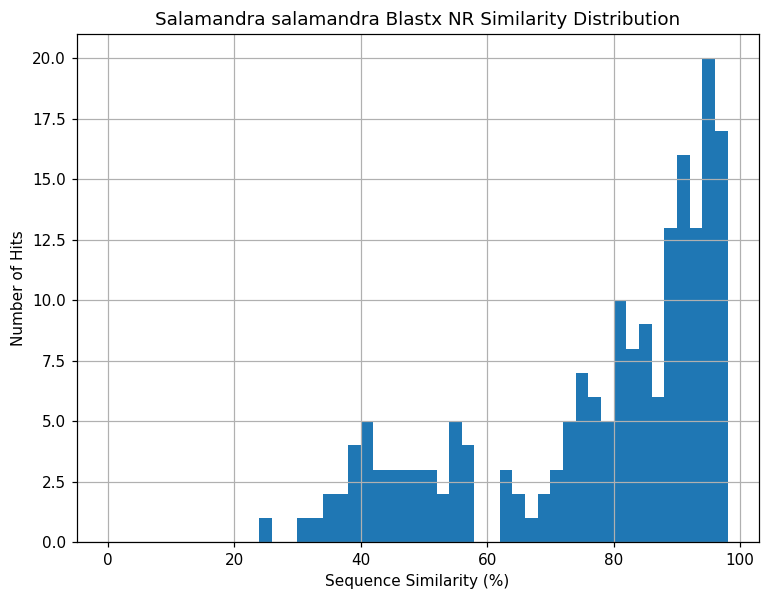

In [103]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Sort the data and create the histogram
pidents.sort_values(inplace=True, ascending=True)
pidents.reset_index(drop=True, inplace=True)
plt.hist(pidents.values, bins=[x for x in range(0, max(int(max(pidents.values)), 1), max(1, int(max(pidents.values))//50))])

# Add labels and title
plt.xlabel('Sequence Similarity (%)')
plt.ylabel('Number of Hits')
plt.title(title + ' Similarity Distribution')

# Add a grid
plt.grid(True)

# Save and show the plot
plt.savefig(path + '_similarity.png', bbox_inches = 'tight', dpi=300)
plt.show()

## Species Distribution

The bar chart with the distribution of species is important because it provides an overview of the organisms with the highest number of hits in the annotation database. This information can be used to understand the evolutionary relationships between different species and to identify the most frequent biological processes or functions associated with the annotated genes.

In this section, it is possible to obtain a bar chart that represents the distribution of species (in scientific names) of the organisms that have obtained the most hits in the database.

To obtain the results in this section, it is essential to have the scientific name ('sscinames') information in the output file.

In [104]:
#Get the scientific names of the organism from the output
scinames = df["sscinames"].value_counts()

#Sorting and adjust the indexes
scinames.sort_values(inplace=True)
scinames.reset_index(drop=True)

#Insert the number of results (default 20)
results_number = 20

#Drop the last len(h) - results_number lines, only if  len(h) > results_number
if len(scinames) > results_number:
    scinames.drop(scinames.head(len(scinames) - results_number).index, inplace=True)

#Set appropriate figsize
plt.rcParams["figure.figsize"] = (8, min(results_number//2 - results_number//4 + 1, len(scinames)//2 - len(scinames)//4 + 2))

And finally, plot!

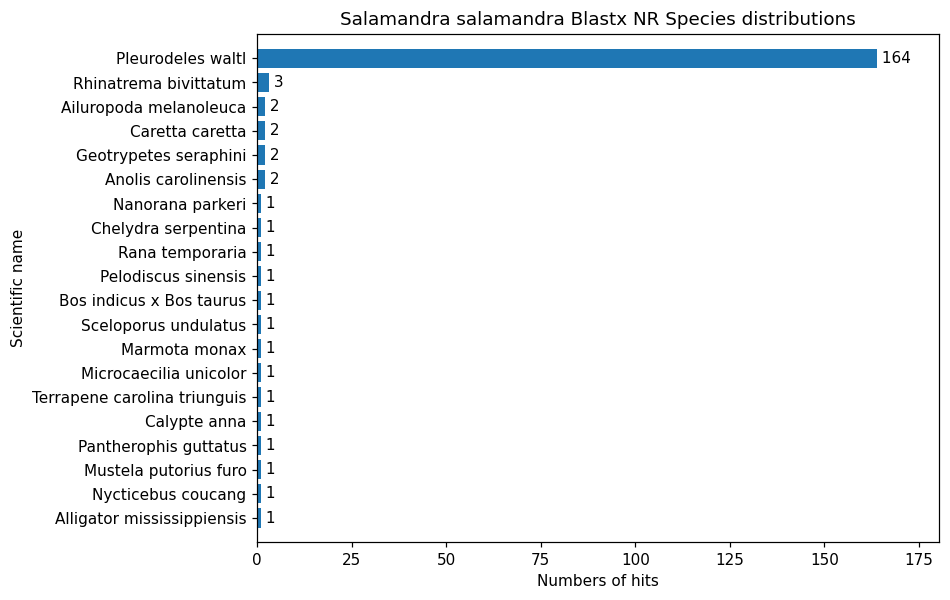

In [105]:
#Adjust the axis limits
plt.ylim([-1,len(scinames.index)])
plt.xlim([0, scinames.max() + scinames.max()*0.1])

#Insert lables
for index, value in enumerate(scinames.values):
    plt.text(value, index, " " + str(value), va='center')

#Adding proper labels
plt.xlabel('Numbers of hits')
plt.ylabel('Scientific name')
plt.title(title + ' Species distributions')

#Plot!
plt.barh(scinames.index, scinames.values)
plt.savefig(path + '_species2.png', bbox_inches = 'tight', dpi=350)
plt.show()